# University of Aberdeen

## Applied AI (CS5079)

### Tutorial (Day 3) - Reinforcement Learning with OpenAI Gym

---

The practical is inspired from the code on: https://github.com/ageron/handson-ml/blob/master/16_reinforcement_learning.ipynb


## Learning Outcomes

On successful completion of this component a student will have demonstrated competence in creating and training an agent to play an Atari game using the screen frames as input

### In this tutorial, we will use the following libraries and modules

In [1]:
!pip install git+https://github.com/openai/baselines.git


  Running command git clone --filter=blob:none -q https://github.com/openai/baselines.git 'C:\Users\alexa\AppData\Local\Temp\pip-req-build-f2aeq3pg'



  Cloning https://github.com/openai/baselines.git to c:\users\alexa\appdata\local\temp\pip-req-build-f2aeq3pg
  Resolved https://github.com/openai/baselines.git to commit ea25b9e8b234e6ee1bca43083f8f3cf974143998
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


In [20]:
# For deep neural networks
import tensorflow as tf

from baselines.common.atari_wrappers import make_atari, wrap_deepmind
from tensorflow import keras
from tensorflow.keras import layers

# For data representation
import numpy as np
import random

# For handling files
import os

# For plotting graphs
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# OpenAI Gym
import gym
env = gym.make("Asterix-v0")
env = wrap_deepmind(env, frame_stack=True, scale=True, clip_rewards=False, episode_life=False)
env.seed(1337)
# I have installed pyglet-1.5.11 for it work with BigSur

c:\users\public\masters\symbolic\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[1337, 17452119]

## Atari Games

In this tutorial, we will create an agent to play the Boxing Atari game. In this game, two boxers, one white and one black, compete against each other. When close enough, a boxer can hit his opponent with a punch which causes his opponent to reel back slightly. A match is completed either when one player lands 100 punches or two minutes have elapsed. In the case of a decision, the player with the most landed punches is the winner. Ties are possible. 

![Activision's Boxing Cartridge](img/Boxing.png)

In this tutorial, we will use the pixels as inputs. The OpenAI Gym environment is `Boxing-v0`. 

### Naive Agent
1.1. For the boxing game, describe the observations, the action space, the reward, the environment’s info dictionary and the episode.


In [21]:
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Possible actions:", env.unwrapped.get_action_meanings())

Observation space: Box(84, 84, 4)
Action space: Discrete(9)
Possible actions: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


The observation space is an RGB picture of size 210x160 whereas the action space is composed of the 18 possible moves from an ATARI controller. The info dictionary contains `ale.lives()` which refers to the number of lives left (but here there is no finite number of lives).

1.2. Create a simple agent that performs random actions.

In [22]:
class RandomAgent():
    def __init__(self, env):
        self.action_size = env.action_space.n
        
    def get_action(self, observation):
        return random.choice(range(self.action_size))
    
total_reward=0
agent = RandomAgent(env)
numberOfEpisodes = 10
# for steps in range(numberOfEpisodes):
#     current_obs = env.reset()
#     done = False
#     while not done:
#         action = agent.get_action(current_obs)
#         next_obs, reward, done, info = env.step(action)
#         total_reward += reward
#         env.render()
print("Average reward: {}".format(total_reward/numberOfEpisodes))

Average reward: 0.0


### Deep Q-Learning Agent

1.3. Implement a pre-processing function to convert the $210\times160$ RGB frames to $96\times80$ greyscale frames. Then, change the type of the matrix to `int8`.


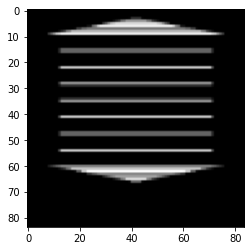

In [29]:
obs = env.reset()
from skimage.color import rgb2gray

def preprocess_observation(observation):
    img = observation[23:153:2, ::2] # This becomes 90, 80, 3
#     print(img.shape)
#     print(img.shape)
#     img = img.mean(axis=2) #to grayscale (values between 0 and 255)
    img = rgb2gray(img)
    img = img.astype(np.float32) # normalize from -128 to 127
    return img.reshape(65, 80)


plt.imshow(obs[:,:,0], cmap='gray')
plt.show()


1.4. Create a function `q_network` that (1) takes as input a variable of shape $(96,80,1)$, (2) creates a deep convolutional network with 3 convolutional hidden layers and two dense layers, and (3) returns the output layer and the trainable variables in a dictionary where the keys are the name of the variables.

In [30]:
# Import the Keras layer used for building our models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,\
MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeUniform

INPUT_SHAPE = (84, 84, 4)
NUM_ACTIONS = env.action_space.n
BATCH_SIZE = 32
FRAME_STACK_SIZE = 4
MEMORY_SIZE = 25000
MIN_REPLAY_SIZE = 20000
LEARNING_RATE = 0.0001

1.5. Create an agent `QLearningAgent` with two deep convolutional networks (`online` and `target`) to predict the action to be taken from the game's frames. The `online` network will be trained and replace the `target`network every $5000$ training steps.


1.6. Create a method `get_action` using a parameter $\epsilon$ for making random moves. This parameter will decrease from $1$ to $0.1$.

1.7. Create a method `train` to update the weights of the `online` network using the Q-values of the `target` network. We will use a discount rate of $0.99$. 

In [31]:
from collections import deque

class QLearningAgent():
    def __init__(self, env, lr=LEARNING_RATE):
        self.lr = lr
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.loss_val = np.inf
        self.action_size = NUM_ACTIONS
        tf.compat.v1.disable_eager_execution()
        self.discount_rate = 0.99
        self.checkpoint_path = "./my_dqn.ckpt"

        # Create the two networks for predicting the actions
        # The first model makes the predictions for Q-values 
        # which are used to make a action.
        self.online = self.q_network()
        
        # Build a target model for the prediction of future
        # rewards. The weights of a target model get updated 
        # every 5000 steps thus when the loss between the 
        # Q-values is calculated the target Q-value is stable.
        self.target = self.q_network()

        #The "target" DNN will take the values of the "online" DNN
        self.update_target()

        # Saving the session
#         self.saver = tf.compat.v1.train.Saver()
#         self.sess = tf.compat.v1.Session()
#         if os.path.isfile(self.checkpoint_path + ".index"):
#             self.saver.restore(self.sess, self.checkpoint_path)
#         else:
# #             self.sess.run(tf.global_variables_initializer())
#             self.update_target()
# #             self.sess.run(self.copy_online_to_target)

    def q_network(self, filters_1=32, filters_2=64, filters_3=64, units=256):
        """Define and return the CNN model architecture
        """
        # Ensure reproducibility of the results
        # by resetting the random seeds
        # reset_random_seeds()

        # Build the model
        kernel_init = HeUniform()
        model = Sequential()
        model.add(Conv2D(filters_1, kernel_size=8, padding="same", strides=4, activation='relu', input_shape=INPUT_SHAPE, kernel_initializer=kernel_init))
        model.add(Conv2D(filters_2, kernel_size=4, padding="same", strides=2, activation='relu', kernel_initializer=kernel_init))
        model.add(Conv2D(filters_3, kernel_size=3, padding="same", strides=1, activation='relu', kernel_initializer=kernel_init))
        model.add(Flatten())
        model.add(Dense(512, activation='relu', kernel_initializer=kernel_init))
        model.add(Dense(NUM_ACTIONS, activation="linear", kernel_initializer=kernel_init))
        model.compile(loss="huber_loss", optimizer=Adam(learning_rate=self.lr))
        return model
            
    def update_target(self):
        """Update the target network with the online network weights
        """
        # Get the online DQN weights
        online_weights = self.online.get_weights()
        
        # Update the target DQN weights
        self.target.set_weights(online_weights)
        
    #---- CHOSSING ACTION ----
    def get_action(self, state, step):
        epsilon = max(0.1, 1 - (0.9/2000000) * step)
        if step <= MIN_REPLAY_SIZE or np.random.rand() < epsilon:
            return np.random.randint(self.action_size) # random action
        else:
            q_values = self.online.predict(state.reshape(-1, *INPUT_SHAPE))
            return np.argmax(q_values) # optimal action
    
    def train(self):
        """Train the online model and update the loss value
        """
        if len(self.memory) < BATCH_SIZE:
            return
        
        # https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf SAY ABOUT NUMBER OF FRAMES
        samples = random.sample(self.memory, BATCH_SIZE)
        
        curr_states = np.array([sample[0] for sample in samples])
#         curr_states = np.stack([self.stack_frames(idx) for idx in sample_indexes])
        states_q_vals = self.online.predict(curr_states)
        
#         next_states = np.stack([self.stack_frames(idx, 3) for idx in sample_indexes])
        next_states = np.array([sample[3] for sample in samples])
        targets_q_vals = self.target.predict(next_states)

        Y = []
        
        for idx, (curr_state, action, reward, next_state, done) in enumerate(samples):
            if done:
                future_q_val = reward
            else:
                future_q_val = reward + np.amax(targets_q_vals[idx]) * self.discount_rate
            
            # Get the current Q value
            curr_q_val = states_q_vals[idx]
            curr_q_val[action] = future_q_val
#             curr_q_val[action] = (1 - learning_rate) * curr_q_val[action] + learning_rate * future_q_val
            Y.append(curr_q_val)
            
        hist = self.online.fit(curr_states, np.array(Y), batch_size=BATCH_SIZE, epochs=1, verbose=0, shuffle=True)
        self.loss_val = hist.history['loss'][0]
    
    def stack_frames(self, end_idx, sample_index=0):
        # https://github.com/kevinchn/atari-dqn/blob/master/dqn.py
        start_idx = end_idx - FRAME_STACK_SIZE + 1
        stack = []
        for idx in range(start_idx, end_idx + 1):
            stack.append(self.memory[idx % MEMORY_SIZE][sample_index])
        return np.stack(stack, axis=-1)
    
    def save_to_memory(self, curr_state, action, reward, next_state, done):
        self.memory.append([curr_state, action, reward, next_state, done])
    
    def get_current_frame_stack(self):
        return np.expand_dims(self._stack_frame(self.current_idx), axis=0)

1.8. Train your network for $1,000,000$ training steps. Since the training process can take __a lot of time__, save your models every $1000$ training steps. You can choose to only train your model every $4$ frames instead of every frames.

In [32]:
import time
agent = QLearningAgent(env)  
ep_rewards = []
total_reward = 0
n_steps = 1000000  # total number of training steps
save_steps = 50


# Train the model after 4 actions
train_online_steps = 4

# Update teh target every 10,000 steps (1 epoch)
# Considered as a hyperparameter
update_target_steps = 10000

done=True
for step in range(n_steps):
    total_perc = step * 100 / n_steps
    print(f"\r\tAction step: {step}/{n_steps} ({total_perc:.2f}%)\tLoss: {agent.loss_val:5f}", end="")
    if done: # game over, start again
        avg_reward = int(total_reward/3)
        if total_reward:
            ep_rewards.append(total_reward)
        print(f"\tAVG reward: {avg_reward}\tTotal mean: {np.mean(ep_rewards)}")
        state = np.array(env.reset())
        total_reward = 0
#         state = preprocess_observation(obs)


    # Get a exploration/exploitation action depending on the
    # current epsilon value
#     q_values = agent.online.predict(state)
    action = agent.get_action(state, step)

    # Online DQN plays
    next_state, reward, done, info = env.step(action)
    next_state = np.array(next_state)
#     next_state = preprocess_observation(next_obs)
    agent.save_to_memory(state, action, reward, next_state, done)
    
    if step > MIN_REPLAY_SIZE:
        if step % train_online_steps == 0:
            agent.train()

        # Regularly copy the online DQN to the target DQN
        if step % update_target_steps == 0:
            agent.update_target()
    
    env.render()
    total_reward += reward
    state = next_state
    # And save regularly
#     if step % save_steps == 0:
#         agent.saver.save(agent.sess, agent.checkpoint_path)
env.close()

	Action step: 0/1000000 (0.00%)	Loss:   inf	AVG reward: 0	Total mean: nan


c:\users\public\masters\symbolic\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\public\masters\symbolic\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


	Action step: 412/1000000 (0.04%)	Loss:   inf	AVG reward: 83	Total mean: 250.0
	Action step: 787/1000000 (0.08%)	Loss:   inf	AVG reward: 66	Total mean: 225.0
	Action step: 1144/1000000 (0.11%)	Loss:   inf	AVG reward: 66	Total mean: 216.66666666666666
	Action step: 1436/1000000 (0.14%)	Loss:   inf	AVG reward: 66	Total mean: 212.5
	Action step: 1713/1000000 (0.17%)	Loss:   inf	AVG reward: 16	Total mean: 180.0
	Action step: 2005/1000000 (0.20%)	Loss:   inf	AVG reward: 33	Total mean: 166.66666666666666
	Action step: 2303/1000000 (0.23%)	Loss:   inf	AVG reward: 66	Total mean: 171.42857142857142
	Action step: 2737/1000000 (0.27%)	Loss:   inf	AVG reward: 150	Total mean: 206.25
	Action step: 3073/1000000 (0.31%)	Loss:   inf	AVG reward: 83	Total mean: 211.11111111111111
	Action step: 3377/1000000 (0.34%)	Loss:   inf	AVG reward: 83	Total mean: 215.0
	Action step: 3664/1000000 (0.37%)	Loss:   inf	AVG reward: 50	Total mean: 209.0909090909091
	Action step: 3940/1000000 (0.39%)	Loss:   inf	AVG rewar

c:\users\public\masters\symbolic\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


	Action step: 20183/1000000 (2.02%)	Loss: 0.000183	AVG reward: 166	Total mean: 272.32142857142856
	Action step: 20699/1000000 (2.07%)	Loss: 0.000166	AVG reward: 183	Total mean: 277.1929824561403
	Action step: 20993/1000000 (2.10%)	Loss: 0.172077	AVG reward: 100	Total mean: 277.58620689655174
	Action step: 21374/1000000 (2.14%)	Loss: 0.000215	AVG reward: 100	Total mean: 277.96610169491527
	Action step: 21721/1000000 (2.17%)	Loss: 0.171878	AVG reward: 83	Total mean: 277.5
	Action step: 22213/1000000 (2.22%)	Loss: 0.000121	AVG reward: 116	Total mean: 278.6885245901639
	Action step: 22570/1000000 (2.26%)	Loss: 0.000117	AVG reward: 116	Total mean: 279.83870967741933
	Action step: 22844/1000000 (2.28%)	Loss: 0.000237	AVG reward: 16	Total mean: 276.1904761904762
	Action step: 23217/1000000 (2.32%)	Loss: 0.000160	AVG reward: 133	Total mean: 278.125
	Action step: 23674/1000000 (2.37%)	Loss: 0.171644	AVG reward: 200	Total mean: 283.0769230769231
	Action step: 24020/1000000 (2.40%)	Loss: 0.171800

	Action step: 51240/1000000 (5.12%)	Loss: 0.001051	AVG reward: 66	Total mean: 279.92957746478874
	Action step: 51516/1000000 (5.15%)	Loss: 0.001576	AVG reward: 33	Total mean: 278.6713286713287
	Action step: 51797/1000000 (5.18%)	Loss: 0.165998	AVG reward: 116	Total mean: 279.1666666666667
	Action step: 52051/1000000 (5.21%)	Loss: 0.001207	AVG reward: 50	Total mean: 278.2758620689655
	Action step: 52377/1000000 (5.24%)	Loss: 0.000728	AVG reward: 100	Total mean: 278.4246575342466
	Action step: 52705/1000000 (5.27%)	Loss: 0.170880	AVG reward: 100	Total mean: 278.57142857142856
	Action step: 53079/1000000 (5.31%)	Loss: 0.170474	AVG reward: 116	Total mean: 279.05405405405406
	Action step: 53364/1000000 (5.34%)	Loss: 0.000682	AVG reward: 83	Total mean: 278.8590604026846
	Action step: 53843/1000000 (5.38%)	Loss: 0.001818	AVG reward: 150	Total mean: 280.0
	Action step: 54129/1000000 (5.41%)	Loss: 0.172808	AVG reward: 33	Total mean: 278.8079470198675
	Action step: 54697/1000000 (5.47%)	Loss: 0.

	Action step: 110426/1000000 (11.04%)	Loss: 0.005964	AVG reward: 83	Total mean: 277.9742765273312
	Action step: 110738/1000000 (11.07%)	Loss: 0.006733	AVG reward: 66	Total mean: 277.72435897435895
	Action step: 111033/1000000 (11.10%)	Loss: 0.175533	AVG reward: 66	Total mean: 277.47603833865816
	Action step: 111410/1000000 (11.14%)	Loss: 0.003030	AVG reward: 83	Total mean: 277.38853503184714
	Action step: 111703/1000000 (11.17%)	Loss: 0.002751	AVG reward: 50	Total mean: 276.984126984127
	Action step: 112048/1000000 (11.20%)	Loss: 0.010924	AVG reward: 100	Total mean: 277.05696202531647
	Action step: 112382/1000000 (11.24%)	Loss: 0.004270	AVG reward: 83	Total mean: 276.9716088328076
	Action step: 112673/1000000 (11.27%)	Loss: 0.144954	AVG reward: 33	Total mean: 276.41509433962267
	Action step: 113018/1000000 (11.30%)	Loss: 0.006151	AVG reward: 50	Total mean: 276.01880877742946
	Action step: 113317/1000000 (11.33%)	Loss: 0.011605	AVG reward: 66	Total mean: 275.78125
	Action step: 113719/1

	Action step: 170837/1000000 (17.08%)	Loss: 0.187239	AVG reward: 66	Total mean: 284.59119496855345
	Action step: 171140/1000000 (17.11%)	Loss: 0.013920	AVG reward: 50	Total mean: 284.30962343096235
	Action step: 171438/1000000 (17.14%)	Loss: 0.035347	AVG reward: 16	Total mean: 283.8204592901879
	Action step: 171729/1000000 (17.17%)	Loss: 0.176635	AVG reward: 33	Total mean: 283.4375
	Action step: 172334/1000000 (17.23%)	Loss: 0.171194	AVG reward: 216	Total mean: 284.1995841995842
	Action step: 172615/1000000 (17.26%)	Loss: 0.012440	AVG reward: 16	Total mean: 283.7136929460581
	Action step: 172926/1000000 (17.29%)	Loss: 0.195129	AVG reward: 66	Total mean: 283.54037267080747
	Action step: 173232/1000000 (17.32%)	Loss: 0.187201	AVG reward: 83	Total mean: 283.4710743801653
	Action step: 173608/1000000 (17.36%)	Loss: 0.177731	AVG reward: 66	Total mean: 283.29896907216494
	Action step: 173883/1000000 (17.39%)	Loss: 0.004785	AVG reward: 50	Total mean: 283.0246913580247
	Action step: 174311/100

	Action step: 231092/1000000 (23.11%)	Loss: 0.176421	AVG reward: 100	Total mean: 284.8367029548989
	Action step: 231371/1000000 (23.14%)	Loss: 0.042275	AVG reward: 66	Total mean: 284.7049689440994
	Action step: 231713/1000000 (23.17%)	Loss: 0.017679	AVG reward: 50	Total mean: 284.49612403100775
	Action step: 232090/1000000 (23.21%)	Loss: 0.365099	AVG reward: 100	Total mean: 284.5201238390093
	Action step: 232672/1000000 (23.27%)	Loss: 0.020096	AVG reward: 216	Total mean: 285.08500772797527
	Action step: 232967/1000000 (23.30%)	Loss: 0.048214	AVG reward: 33	Total mean: 284.79938271604937
	Action step: 233365/1000000 (23.34%)	Loss: 0.197965	AVG reward: 183	Total mean: 285.2080123266564
	Action step: 233675/1000000 (23.37%)	Loss: 0.011383	AVG reward: 100	Total mean: 285.2307692307692
	Action step: 234048/1000000 (23.40%)	Loss: 0.024484	AVG reward: 116	Total mean: 285.33026113671275
	Action step: 234689/1000000 (23.47%)	Loss: 0.021781	AVG reward: 233	Total mean: 285.96625766871165
	Action 

	Action step: 262670/1000000 (26.27%)	Loss: 0.040452	AVG reward: 66	Total mean: 289.25619834710744
	Action step: 262968/1000000 (26.30%)	Loss: 0.057812	AVG reward: 83	Total mean: 289.2022008253095
	Action step: 263338/1000000 (26.33%)	Loss: 0.028553	AVG reward: 100	Total mean: 289.217032967033
	Action step: 263622/1000000 (26.36%)	Loss: 0.015749	AVG reward: 33	Total mean: 288.957475994513
	Action step: 263960/1000000 (26.40%)	Loss: 0.206224	AVG reward: 66	Total mean: 288.83561643835617
	Action step: 264304/1000000 (26.43%)	Loss: 0.032277	AVG reward: 66	Total mean: 288.7140902872777
	Action step: 264725/1000000 (26.47%)	Loss: 0.038996	AVG reward: 183	Total mean: 289.07103825136613
	Action step: 265029/1000000 (26.50%)	Loss: 0.051915	AVG reward: 100	Total mean: 289.08594815825376
	Action step: 265461/1000000 (26.55%)	Loss: 0.186441	AVG reward: 133	Total mean: 289.23705722070844
	Action step: 265737/1000000 (26.57%)	Loss: 0.053831	AVG reward: 33	Total mean: 288.9795918367347
	Action step:

	Action step: 322702/1000000 (32.27%)	Loss: 0.017799	AVG reward: 100	Total mean: 290.2918069584736
	Action step: 322968/1000000 (32.30%)	Loss: 0.036504	AVG reward: 50	Total mean: 290.13452914798205
	Action step: 323408/1000000 (32.34%)	Loss: 0.036317	AVG reward: 166	Total mean: 290.36954087346027
	Action step: 323689/1000000 (32.37%)	Loss: 0.182855	AVG reward: 83	Total mean: 290.324384787472
	Action step: 324143/1000000 (32.41%)	Loss: 0.188342	AVG reward: 200	Total mean: 290.6703910614525
	Action step: 324594/1000000 (32.46%)	Loss: 0.007729	AVG reward: 133	Total mean: 290.7924107142857
	Action step: 325005/1000000 (32.50%)	Loss: 0.065692	AVG reward: 116	Total mean: 290.85841694537345
	Action step: 325314/1000000 (32.53%)	Loss: 0.019163	AVG reward: 83	Total mean: 290.8129175946548
	Action step: 325648/1000000 (32.56%)	Loss: 0.188977	AVG reward: 66	Total mean: 290.7119021134594
	Action step: 325921/1000000 (32.59%)	Loss: 0.047327	AVG reward: 66	Total mean: 290.6111111111111
	Action step:

	Action step: 381591/1000000 (38.16%)	Loss: 0.038514	AVG reward: 66	Total mean: 290.8703878902554
	Action step: 382139/1000000 (38.21%)	Loss: 0.035393	AVG reward: 216	Total mean: 291.20982986767484
	Action step: 382420/1000000 (38.24%)	Loss: 0.269265	AVG reward: 66	Total mean: 291.12370160528803
	Action step: 382900/1000000 (38.29%)	Loss: 0.024557	AVG reward: 183	Total mean: 291.3679245283019
	Action step: 383177/1000000 (38.32%)	Loss: 0.041491	AVG reward: 66	Total mean: 291.2818096135721
	Action step: 383494/1000000 (38.35%)	Loss: 0.023347	AVG reward: 100	Total mean: 291.2900188323917
	Action step: 383953/1000000 (38.40%)	Loss: 0.023623	AVG reward: 150	Total mean: 291.4393226716839
	Action step: 384465/1000000 (38.45%)	Loss: 0.193831	AVG reward: 216	Total mean: 291.7763157894737
	Action step: 384741/1000000 (38.47%)	Loss: 0.048777	AVG reward: 33	Total mean: 291.5962441314554
	Action step: 385035/1000000 (38.50%)	Loss: 0.011306	AVG reward: 50	Total mean: 291.4634146341463
	Action step:

	Action step: 411594/1000000 (41.16%)	Loss: 0.012681	AVG reward: 83	Total mean: 291.9736842105263
	Action step: 412110/1000000 (41.21%)	Loss: 0.012530	AVG reward: 183	Total mean: 292.19982471516215
	Action step: 412463/1000000 (41.25%)	Loss: 0.009582	AVG reward: 83	Total mean: 292.1628721541156
	Action step: 412815/1000000 (41.28%)	Loss: 0.026650	AVG reward: 116	Total mean: 292.21347331583553
	Action step: 413102/1000000 (41.31%)	Loss: 0.029087	AVG reward: 33	Total mean: 292.04545454545456
	Action step: 413521/1000000 (41.35%)	Loss: 0.035169	AVG reward: 200	Total mean: 292.31441048034935
	Action step: 413793/1000000 (41.38%)	Loss: 0.027284	AVG reward: 33	Total mean: 292.14659685863876
	Action step: 414086/1000000 (41.41%)	Loss: 0.026155	AVG reward: 50	Total mean: 292.0226678291194
	Action step: 414425/1000000 (41.44%)	Loss: 0.075921	AVG reward: 100	Total mean: 292.0296167247387
	Action step: 414703/1000000 (41.47%)	Loss: 0.018376	AVG reward: 66	Total mean: 291.9495213228895
	Action ste

	Action step: 440391/1000000 (44.04%)	Loss: 0.191784	AVG reward: 83	Total mean: 291.7416189697465
	Action step: 440866/1000000 (44.09%)	Loss: 0.208062	AVG reward: 116	Total mean: 291.78921568627453
	Action step: 441255/1000000 (44.13%)	Loss: 0.021480	AVG reward: 66	Total mean: 291.7142857142857
	Action step: 441662/1000000 (44.17%)	Loss: 0.031513	AVG reward: 150	Total mean: 291.8433931484502
	Action step: 441941/1000000 (44.19%)	Loss: 0.219666	AVG reward: 50	Total mean: 291.7277913610432
	Action step: 442359/1000000 (44.24%)	Loss: 0.059841	AVG reward: 150	Total mean: 291.85667752443
	Action step: 442631/1000000 (44.26%)	Loss: 0.014817	AVG reward: 50	Total mean: 291.7412530512612
	Action step: 443079/1000000 (44.31%)	Loss: 0.208062	AVG reward: 116	Total mean: 291.7886178861789
	Action step: 443527/1000000 (44.35%)	Loss: 0.069302	AVG reward: 133	Total mean: 291.876523151909
	Action step: 443843/1000000 (44.38%)	Loss: 0.046199	AVG reward: 66	Total mean: 291.80194805194805
	Action step: 44

	Action step: 501257/1000000 (50.13%)	Loss: 0.205792	AVG reward: 83	Total mean: 293.1245500359971
	Action step: 501542/1000000 (50.15%)	Loss: 0.185834	AVG reward: 33	Total mean: 292.9856115107914
	Action step: 501840/1000000 (50.18%)	Loss: 0.016869	AVG reward: 50	Total mean: 292.882818116463
	Action step: 502231/1000000 (50.22%)	Loss: 0.363285	AVG reward: 83	Total mean: 292.85201149425285
	Action step: 502534/1000000 (50.25%)	Loss: 0.011155	AVG reward: 66	Total mean: 292.78535534816945
	Action step: 502911/1000000 (50.29%)	Loss: 0.016896	AVG reward: 100	Total mean: 292.79053084648496
	Action step: 503234/1000000 (50.32%)	Loss: 0.012978	AVG reward: 66	Total mean: 292.72401433691755
	Action step: 503637/1000000 (50.36%)	Loss: 0.018775	AVG reward: 150	Total mean: 292.83667621776505
	Action step: 504006/1000000 (50.40%)	Loss: 0.017764	AVG reward: 100	Total mean: 292.8418038654259
	Action step: 504290/1000000 (50.43%)	Loss: 0.025265	AVG reward: 66	Total mean: 292.77539341917026
	Action step

	Action step: 530626/1000000 (53.06%)	Loss: 0.211209	AVG reward: 183	Total mean: 291.7798913043478
	Action step: 530957/1000000 (53.10%)	Loss: 0.059986	AVG reward: 83	Total mean: 291.7515274949084
	Action step: 531263/1000000 (53.13%)	Loss: 0.024083	AVG reward: 100	Total mean: 291.7571234735414
	Action step: 531615/1000000 (53.16%)	Loss: 0.357460	AVG reward: 83	Total mean: 291.728813559322
	Action step: 531859/1000000 (53.19%)	Loss: 0.024031	AVG reward: 50	Total mean: 291.63279132791325
	Action step: 532273/1000000 (53.23%)	Loss: 0.035285	AVG reward: 116	Total mean: 291.6723087339201
	Action step: 532645/1000000 (53.26%)	Loss: 0.016792	AVG reward: 133	Total mean: 291.745602165088
	Action step: 532925/1000000 (53.29%)	Loss: 0.179524	AVG reward: 50	Total mean: 291.6497633536173
	Action step: 533274/1000000 (53.33%)	Loss: 0.203283	AVG reward: 66	Total mean: 291.5878378378378
	Action step: 533606/1000000 (53.36%)	Loss: 0.204932	AVG reward: 100	Total mean: 291.5935178933153
	Action step: 53

	Action step: 591016/1000000 (59.10%)	Loss: 0.015695	AVG reward: 150	Total mean: 292.24664224664224
	Action step: 591325/1000000 (59.13%)	Loss: 0.176082	AVG reward: 83	Total mean: 292.2208663819402
	Action step: 591620/1000000 (59.16%)	Loss: 0.035958	AVG reward: 83	Total mean: 292.1951219512195
	Action step: 592086/1000000 (59.21%)	Loss: 0.195261	AVG reward: 150	Total mean: 292.2912858013406
	Action step: 592358/1000000 (59.24%)	Loss: 0.010347	AVG reward: 66	Total mean: 292.2350791717418
	Action step: 592618/1000000 (59.26%)	Loss: 0.036630	AVG reward: 83	Total mean: 292.2093730979915
	Action step: 593005/1000000 (59.30%)	Loss: 0.186481	AVG reward: 133	Total mean: 292.2749391727494
	Action step: 593377/1000000 (59.34%)	Loss: 0.007744	AVG reward: 66	Total mean: 292.21884498480244
	Action step: 593664/1000000 (59.37%)	Loss: 0.186065	AVG reward: 50	Total mean: 292.13244228432563
	Action step: 594058/1000000 (59.41%)	Loss: 0.283473	AVG reward: 83	Total mean: 292.10686095932
	Action step: 59

	Action step: 652873/1000000 (65.29%)	Loss: 0.044959	AVG reward: 66	Total mean: 292.3780487804878
	Action step: 653129/1000000 (65.31%)	Loss: 0.018197	AVG reward: 100	Total mean: 292.38227146814404
	Action step: 653542/1000000 (65.35%)	Loss: 0.019855	AVG reward: 116	Total mean: 292.4141749723145
	Action step: 653998/1000000 (65.40%)	Loss: 0.354453	AVG reward: 133	Total mean: 292.4737133370227
	Action step: 654376/1000000 (65.44%)	Loss: 0.018681	AVG reward: 133	Total mean: 292.533185840708
	Action step: 654906/1000000 (65.49%)	Loss: 0.011477	AVG reward: 100	Total mean: 292.53731343283584
	Action step: 655197/1000000 (65.52%)	Loss: 0.011597	AVG reward: 83	Total mean: 292.51381215469615
	Action step: 655475/1000000 (65.55%)	Loss: 0.014493	AVG reward: 50	Total mean: 292.4351187189398
	Action step: 655811/1000000 (65.58%)	Loss: 0.188906	AVG reward: 66	Total mean: 292.3841059602649
	Action step: 656132/1000000 (65.61%)	Loss: 0.004662	AVG reward: 33	Total mean: 292.27799227799227
	Action step

	Action step: 683751/1000000 (68.38%)	Loss: 0.005114	AVG reward: 33	Total mean: 293.08426073131955
	Action step: 684122/1000000 (68.41%)	Loss: 0.013957	AVG reward: 133	Total mean: 293.14088983050846
	Action step: 684412/1000000 (68.44%)	Loss: 0.223325	AVG reward: 50	Total mean: 293.0651138168343
	Action step: 684740/1000000 (68.47%)	Loss: 0.011051	AVG reward: 50	Total mean: 292.989417989418
	Action step: 684978/1000000 (68.50%)	Loss: 0.012369	AVG reward: 50	Total mean: 292.9138022210471
	Action step: 685312/1000000 (68.53%)	Loss: 0.009335	AVG reward: 50	Total mean: 292.838266384778
	Action step: 685587/1000000 (68.56%)	Loss: 0.029834	AVG reward: 83	Total mean: 292.81563655573166
	Action step: 685866/1000000 (68.59%)	Loss: 0.017435	AVG reward: 66	Total mean: 292.76663146779305
	Action step: 686222/1000000 (68.62%)	Loss: 0.011441	AVG reward: 100	Total mean: 292.7704485488127
	Action step: 686533/1000000 (68.65%)	Loss: 0.007336	AVG reward: 116	Total mean: 292.8006329113924
	Action step: 6

	Action step: 745250/1000000 (74.53%)	Loss: 0.007870	AVG reward: 316	Total mean: 293.86264003896736
	Action step: 745788/1000000 (74.58%)	Loss: 0.185710	AVG reward: 166	Total mean: 293.96299902629016
	Action step: 746099/1000000 (74.61%)	Loss: 0.174291	AVG reward: 66	Total mean: 293.9172749391727
	Action step: 746406/1000000 (74.64%)	Loss: 0.186904	AVG reward: 66	Total mean: 293.8715953307393
	Action step: 746704/1000000 (74.67%)	Loss: 0.007346	AVG reward: 33	Total mean: 293.7773456490034
	Action step: 747074/1000000 (74.71%)	Loss: 0.007863	AVG reward: 116	Total mean: 293.8046647230321
	Action step: 747390/1000000 (74.74%)	Loss: 0.182573	AVG reward: 83	Total mean: 293.7833899951433
	Action step: 747671/1000000 (74.77%)	Loss: 0.025581	AVG reward: 66	Total mean: 293.7378640776699
	Action step: 748211/1000000 (74.82%)	Loss: 0.008555	AVG reward: 166	Total mean: 293.83794274623966
	Action step: 748477/1000000 (74.85%)	Loss: 0.009111	AVG reward: 33	Total mean: 293.7439379243453
	Action step:

	Action step: 776523/1000000 (77.65%)	Loss: 0.173614	AVG reward: 66	Total mean: 294.0543071161049
	Action step: 776814/1000000 (77.68%)	Loss: 0.008844	AVG reward: 83	Total mean: 294.03369209171734
	Action step: 777160/1000000 (77.72%)	Loss: 0.009758	AVG reward: 83	Total mean: 294.0130963517306
	Action step: 777440/1000000 (77.74%)	Loss: 0.009036	AVG reward: 33	Total mean: 293.92239364188873
	Action step: 777681/1000000 (77.77%)	Loss: 0.034817	AVG reward: 50	Total mean: 293.8551401869159
	Action step: 778008/1000000 (77.80%)	Loss: 0.185589	AVG reward: 83	Total mean: 293.83465670247546
	Action step: 778286/1000000 (77.83%)	Loss: 0.348582	AVG reward: 83	Total mean: 293.81419234360413
	Action step: 778524/1000000 (77.85%)	Loss: 0.055709	AVG reward: 33	Total mean: 293.7237517498833
	Action step: 778847/1000000 (77.88%)	Loss: 0.007579	AVG reward: 66	Total mean: 293.6800373134328
	Action step: 779294/1000000 (77.93%)	Loss: 0.005811	AVG reward: 133	Total mean: 293.72960372960375
	Action step: 

	Action step: 805539/1000000 (80.55%)	Loss: 0.033680	AVG reward: 66	Total mean: 293.69085173501577
	Action step: 805991/1000000 (80.60%)	Loss: 0.022260	AVG reward: 166	Total mean: 293.7837837837838
	Action step: 806420/1000000 (80.64%)	Loss: 0.181947	AVG reward: 116	Total mean: 293.80909500225124
	Action step: 806837/1000000 (80.68%)	Loss: 0.181306	AVG reward: 133	Total mean: 293.85688568856887
	Action step: 807152/1000000 (80.72%)	Loss: 0.007550	AVG reward: 33	Total mean: 293.7696806117859
	Action step: 807499/1000000 (80.75%)	Loss: 0.047812	AVG reward: 50	Total mean: 293.705035971223
	Action step: 808113/1000000 (80.81%)	Loss: 0.049478	AVG reward: 250	Total mean: 293.91011235955057
	Action step: 808428/1000000 (80.84%)	Loss: 0.856969	AVG reward: 66	Total mean: 293.8679245283019
	Action step: 808838/1000000 (80.88%)	Loss: 0.018483	AVG reward: 83	Total mean: 293.84822631342615
	Action step: 809347/1000000 (80.93%)	Loss: 0.196001	AVG reward: 183	Total mean: 293.9631956912029
	Action ste

	Action step: 866918/1000000 (86.69%)	Loss: 0.019049	AVG reward: 83	Total mean: 294.48637316561843
	Action step: 867183/1000000 (86.72%)	Loss: 0.003744	AVG reward: 50	Total mean: 294.42581726739314
	Action step: 867563/1000000 (86.76%)	Loss: 0.178200	AVG reward: 133	Total mean: 294.4700460829493
	Action step: 867932/1000000 (86.79%)	Loss: 0.018626	AVG reward: 83	Total mean: 294.4514237855946
	Action step: 868389/1000000 (86.84%)	Loss: 0.011723	AVG reward: 116	Total mean: 294.4746755964839
	Action step: 868786/1000000 (86.88%)	Loss: 0.177130	AVG reward: 100	Total mean: 294.4769874476987
	Action step: 869122/1000000 (86.91%)	Loss: 0.007729	AVG reward: 33	Total mean: 294.3956503554998
	Action step: 869663/1000000 (86.97%)	Loss: 0.013848	AVG reward: 150	Total mean: 294.4607023411371
	Action step: 870059/1000000 (87.01%)	Loss: 0.180118	AVG reward: 116	Total mean: 294.48391140827414
	Action step: 870326/1000000 (87.03%)	Loss: 0.035388	AVG reward: 33	Total mean: 294.40267335004177
	Action ste

	Action step: 899288/1000000 (89.93%)	Loss: 0.009507	AVG reward: 50	Total mean: 295.25931928687197
	Action step: 899567/1000000 (89.96%)	Loss: 0.008759	AVG reward: 16	Total mean: 295.15998379910894
	Action step: 899907/1000000 (89.99%)	Loss: 0.027423	AVG reward: 116	Total mean: 295.18218623481783
	Action step: 900352/1000000 (90.04%)	Loss: 0.042527	AVG reward: 183	Total mean: 295.2853095912586
	Action step: 900629/1000000 (90.06%)	Loss: 0.006542	AVG reward: 66	Total mean: 295.24676375404533
	Action step: 900952/1000000 (90.10%)	Loss: 0.011032	AVG reward: 83	Total mean: 295.2284674484432
	Action step: 901219/1000000 (90.12%)	Loss: 0.011840	AVG reward: 33	Total mean: 295.1495553759095
	Action step: 901452/1000000 (90.15%)	Loss: 0.006070	AVG reward: 66	Total mean: 295.1111111111111
	Action step: 901848/1000000 (90.18%)	Loss: 0.009784	AVG reward: 100	Total mean: 295.1130856219709
	Action step: 902280/1000000 (90.23%)	Loss: 0.006106	AVG reward: 150	Total mean: 295.1756156641098
	Action step

	Action step: 958537/1000000 (95.85%)	Loss: 0.018740	AVG reward: 100	Total mean: 295.3682611996963
	Action step: 958993/1000000 (95.90%)	Loss: 0.006445	AVG reward: 166	Total mean: 295.4459203036053
	Action step: 959273/1000000 (95.93%)	Loss: 0.182605	AVG reward: 66	Total mean: 295.4097116843703
	Action step: 959539/1000000 (95.95%)	Loss: 0.169587	AVG reward: 16	Total mean: 295.3166477057262
	Action step: 959847/1000000 (95.98%)	Loss: 0.012155	AVG reward: 66	Total mean: 295.28051554207735
	Action step: 960350/1000000 (96.03%)	Loss: 0.010187	AVG reward: 200	Total mean: 295.3959833270178
	Action step: 960722/1000000 (96.07%)	Loss: 0.048433	AVG reward: 83	Total mean: 295.3787878787879
	Action step: 961042/1000000 (96.10%)	Loss: 0.188351	AVG reward: 33	Total mean: 295.3048087845513
	Action step: 961347/1000000 (96.13%)	Loss: 0.038057	AVG reward: 66	Total mean: 295.2687358062074
	Action step: 961813/1000000 (96.18%)	Loss: 0.014587	AVG reward: 166	Total mean: 295.3461975028377
	Action step: 9

	Action step: 990114/1000000 (99.01%)	Loss: 0.014668	AVG reward: 33	Total mean: 296.4666912035333
	Action step: 990447/1000000 (99.04%)	Loss: 0.348563	AVG reward: 83	Total mean: 296.4495952906549
	Action step: 990818/1000000 (99.08%)	Loss: 0.013031	AVG reward: 100	Total mean: 296.4509010665686
	Action step: 991096/1000000 (99.11%)	Loss: 0.048598	AVG reward: 50	Total mean: 296.3970588235294
	Action step: 991423/1000000 (99.14%)	Loss: 0.011696	AVG reward: 100	Total mean: 296.3983829474458
	Action step: 991756/1000000 (99.18%)	Loss: 0.004079	AVG reward: 83	Total mean: 296.38133725202056
	Action step: 992157/1000000 (99.22%)	Loss: 0.055293	AVG reward: 133	Total mean: 296.41939037825927
	Action step: 992729/1000000 (99.27%)	Loss: 0.158590	AVG reward: 183	Total mean: 296.5124816446402
	Action step: 993001/1000000 (99.30%)	Loss: 0.016375	AVG reward: 66	Total mean: 296.4770642201835
	Action step: 993277/1000000 (99.33%)	Loss: 0.169515	AVG reward: 100	Total mean: 296.4783565663977
	Action step:

In [34]:
print(ep_rewards)

[250.0, 200.0, 200.0, 200.0, 50.0, 100.0, 200.0, 450.0, 250.0, 250.0, 150.0, 200.0, 150.0, 500.0, 550.0, 250.0, 200.0, 150.0, 200.0, 350.0, 250.0, 150.0, 250.0, 350.0, 200.0, 400.0, 200.0, 200.0, 150.0, 300.0, 200.0, 100.0, 350.0, 200.0, 350.0, 150.0, 100.0, 350.0, 500.0, 400.0, 100.0, 400.0, 350.0, 150.0, 300.0, 200.0, 250.0, 150.0, 300.0, 350.0, 150.0, 350.0, 350.0, 550.0, 800.0, 500.0, 550.0, 300.0, 300.0, 250.0, 350.0, 350.0, 50.0, 400.0, 600.0, 300.0, 350.0, 50.0, 150.0, 400.0, 200.0, 300.0, 150.0, 100.0, 200.0, 100.0, 650.0, 250.0, 300.0, 250.0, 100.0, 550.0, 400.0, 300.0, 550.0, 100.0, 250.0, 350.0, 250.0, 600.0, 400.0, 400.0, 450.0, 350.0, 300.0, 350.0, 50.0, 200.0, 350.0, 150.0, 200.0, 300.0, 150.0, 500.0, 250.0, 100.0, 300.0, 300.0, 250.0, 250.0, 50.0, 400.0, 300.0, 150.0, 200.0, 200.0, 200.0, 200.0, 150.0, 100.0, 150.0, 100.0, 100.0, 850.0, 250.0, 300.0, 300.0, 250.0, 250.0, 150.0, 350.0, 300.0, 100.0, 200.0, 700.0, 350.0, 650.0, 150.0, 200.0, 500.0, 200.0, 200.0, 100.0, 350

1.8. Print the evolution of the total number of rewards w.r.t. the episodes.

1.9. Analyse the behaviour of the saved agents, can you notice any emerging strategies?

https://www.youtube.com/watch?v=OxOqLQ8Ed_k

In [ ]:
np.stack([1,2,3]).reshape(3,1)

In [36]:
import pandas as pd
x = pd.DataFrame(data=ep_rewards)
x

,0
0,250.0
1,200.0
2,200.0
3,200.0
4,50.0
...,...
2740,200.0
2741,450.0
2742,550.0
2743,250.0
